In [1]:
from netCDF4 import Dataset
import numpy as np
from mpl_toolkits.basemap import Basemap, maskoceans
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs

"""
script to calculate divergence from model output
using different grid samplings
"""

def cm2inch(*tupl):
    """
    Useful conversion for plotting for Europeans
    """
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

    
def int_dwdz(dudx, dvdy, dz):
    """
    Function to trapezoidally integrate w from 
    top to bottom
    arguments: dudx, dvdy, dz
    returns: w
    """
    dwdz = -(dudx+dvdy)
    w = (dwdz[:-1] + dwdz[1:])/2 * dz[:-1] # is this correct?? -> calc dudz dvdy * dz at correct intervals
    w = np.insert(w,0,0)
    return w


model_name = 'CESM-POP'
force_data = 'JRA55'
force_type = 'IAF'
hres = 0.1
exp_name = 'g.e20.G.TL319_t13.control.001'
file_type = '.pop.h.'
year = 25
yoffset = 1957
file_model = exp_name + file_type + str(year).zfill(4) + '.nc'
    
# path definitions
bpath = '/glade/p/cgd/oce/projects/'
forcing = 'JRA55/'
ftype = 'IAF/'
expcase = 'g.e20.G.'
resol = 'TL319_t13'
to = 'ocn/'
jra5daypth= '/glade/scratch/altuntas/archive/g.e20.G.TL319_t13.control.001_hfreq/ocn/hist/'
jramonpth = bpath + forcing + ftype +  expcase + resol + '.control.001/'+ to + 'hist/'
jratavgpth = bpath + forcing + ftype +  expcase + resol + '.control.001/ocn/tavg/'

force = 'CORE-II'
coretavgpth = bpath + force + ftype + 'g.e01.GIAF.T62_t12.003/ocn/proc/tavg/'
corepth = bpath + force + ftype + 'g.e01.GIAF.T62_t12.003/ocn/proc/' # this path has mnth + 5day avg

# grid dir independent of which year and forcing
grid_p = '/glade/work/deppenme/help_dir/'
grid_f = 'grid.tx01_62l.2013-07-13.nc'

lon_plt = 220.
dep_plt1 = 60.0
lat_range = [-8,8]

w_factor = 86400.0/100.0      # cm/sec to m/day
earth_radius = 6367.0e5       ## in cm
dt = 10.0*86400.0             ##  in days

# for later 1990-1991 output 
# pth = '/glade/p/cgd/oce/projects/CORE-II/IAF/g.e01.GIAF.T62_t12.003/ocn/proc/tavg'

In [2]:
# get the infrastructure for the data, grid info and indices and such

ds_grid = xr.open_dataset(grid_p + grid_f)
ULAT = ds_grid.ULAT.data[:]
ULON = ds_grid.ULONG.data[:]
DXU = ds_grid.DXU.data[:]/100
DYU = ds_grid.DYU.data[:]/100
dz = ds_grid.dz.data[:]/100
dzw = ds_grid.dzw.data[:]/100 # convert all to m

zw = ds_grid.z_w_top.data[:]/100.
zt = ds_grid.z_t.data[:]/100.

nlon = np.shape(ULON)[1]
nlat = np.shape(ULON)[0]
ndep = np.shape(zt)[0]

j_eq = (np.abs(ULAT[:,0])).argmin()
i_roll = (np.abs(ULON[j_eq,:])).argmin()
j_5n = (np.abs(ULAT[:,0] - 5.0).argmin()) + 1
j_5s = (np.abs(ULAT[:,0] + 5.0).argmin()) - 1
j_15n = (np.abs(ULAT[:,0] - 15.0).argmin()) + 1
j_15s = (np.abs(ULAT[:,0] + 15.0).argmin()) - 1
print('Indices. Lat eq: ', j_eq, ' - ', 'Roll Lon by: ',  i_roll, ' - ', 'Lat 15N: ', j_15n, ' - ', 'Lat 15S: ', j_15s)

# move so that boundary is not directly in our region
ULON = np.roll( ULON, -i_roll, axis=1 )
ULAT = np.roll( ULAT, -i_roll, axis=1 )
TLON = np.roll( ds_grid.TLONG.data[:], -i_roll, axis=1 )
TLAT = np.roll( ds_grid.TLAT.data[:], -i_roll, axis=1 ) 
KMT = np.roll( ds_grid.KMT.data[:], -i_roll,axis=1 )
RMASK = np.roll( ds_grid.REGION_MASK.data[:], -i_roll, axis=1 )

# check on longs and make sure ulon increases monotonically
print('ULON min, max values = ',np.min(ULON),np.max(ULON))
print('ULON[0] = ', ULON[j_eq,0], ' ... ULON[nlon-2] = ', ULON[j_eq,nlon-2],' ULON[nlon-1]=',ULON[j_eq,nlon-1])

ULON = np.where(ULON < 0, ULON + 360.0, ULON)

print( 'ULON[0] = ', ULON[j_eq,0], ' ... ULON[nlon-2] = ', ULON[j_eq,nlon-2],' ULON[nlon-1] = ', ULON[j_eq,nlon-1])

#find pacific indices
ULON_PAC = np.ma.masked_where(RMASK != 2,ULON)
i_dateline = (np.abs(ULON[j_eq,:] - 180.0)).argmin()
i_pac_w = np.amin(np.where(ULON_PAC == np.amin(ULON_PAC))[1][:]) - 1
i_pac_e = np.amin(np.where(ULON_PAC == np.amax(ULON_PAC))[1][:]) + 1
i_140w = (np.abs(ULON[j_eq,:] - (360.0-140.0)).argmin())
i_125w = (np.abs(ULON[j_eq,:] - (360.0-125.0)).argmin())

print('ULON min,max in Pacific=',np.amin(ULON_PAC),np.amax(ULON_PAC))
print('i_pac_w=',i_pac_w,' ULON @ Eq = ',ULON[j_eq,i_pac_w])
print('i_pac_e=',i_pac_e,' ULON @ Eq = ',ULON[j_eq,i_pac_e])
print('i_140w=',i_140w,' ULON @ 140w = ',ULON[j_eq,i_140w])
print('i_125w=',i_125w,' ULON @ 125w = ',ULON[j_eq,i_125w])
print('i_dateline=',i_dateline,' ULON = ',ULON[j_eq,i_dateline])

Indices. Lat eq:  1181  -  Roll Lon by:  1099  -  Lat 15N:  1334  -  Lat 15S:  1028
ULON min, max values =  -179.99998130265814 180.0
ULON[0] =  0.0  ... ULON[nlon-2] =  -0.2  ULON[nlon-1]= -0.1
ULON[0] =  0.0  ... ULON[nlon-2] =  359.8  ULON[nlon-1] =  359.9
ULON min,max in Pacific= 99.3 289.9
i_pac_w= 992  ULON @ Eq =  99.2
i_pac_e= 2900  ULON @ Eq =  290.0
i_140w= 2200  ULON @ 140w =  220.00000000000003
i_125w= 2350  ULON @ 125w =  235.0
i_dateline= 1800  ULON =  180.0


In [3]:
# define functions for getting divergence
# this should go up but I am using defaults that don't work before they're defined..
# think about this 

def find_inds_popgrid(n, s, e, w, dlats, dlons, jeq=None, centerlon=140):
        """
        function to find the indices north south east west around 0E 140W
        on a given lat and lon curvilinear grid
        arguments: desired coordinates n, s, e, w, lat info, lon info, center lat (default = eq), center lon (default = 140)
        """
        ila_s = (np.abs(dlats[:,0] - s).argmin()) - 1
        ila_n = (np.abs(dlats[:,0] - n).argmin()) + 1
        if jeq is not None:
            ilo_w = (np.abs(dlons[jeq,:] - (360-centerlon+w)).argmin()) +1
            ilo_e = (np.abs(dlons[jeq,:] - (360-centerlon-e)).argmin()) 
            #print('j_eq provided')
        else:
            jq = int(np.round(len(dlats[:,0])/2.))
            #print('had to think of my own j_eq, this is it: ', jq)
            ilo_w = (np.abs(dlons[jq,:] - (360-centerlon+w)).argmin()) +1
            ilo_e = (np.abs(dlons[jq,:] - (360-centerlon-e)).argmin()) 
        return ila_n, ila_s, ilo_e, ilo_w
    

def calc_hor_div(u, dx, v, dy, ilan, ilas, ilow, iloe, cenla = j_eq, cenlo = i_140w):
    """
    calculate hoirzontal divergenve 
    dudx and dvdy
    arguments: u, dx, v, dy, lats, latn, lonw, lone, center lat (default = eq), center lon (default = 140W)
    returns: dudx, dvdy
    """
    du  = - u[:, cenla, ilow] + u[:, cenla, iloe]
    #print(np.shape(dx[cenla, ilow : iloe ]))
    ddx  = np.sum(dx[cenla, ilow : iloe ])
    #print(ddx)
    dudx = du / ddx
    dv = v[:, ilan, cenlo] - v[:, ilas, cenlo]
    #print(np.shape(DYU[ilan:ilas, cenlo]))
    ddy = np.sum(DYU[ilas:ilan, cenlo])
    dvdy = dv / ddy
    return dudx, dvdy  
   

In [4]:
# get the data you want to use, in this first overall average over last 21 years of simulation
tav_jra = xr.open_dataset(jratavgpth + 'g.e20.G.TL319_t13.control.001_hfreq.pop.tavg.0042-0061.nc')

WVEL = np.roll(tav_jra.WVEL[0,:,:,:].data[:], -i_roll, axis=-1)*w_factor # m / day
UVEL = np.roll(tav_jra.UVEL[0,:,:,:].data[:], -i_roll, axis=-1)/100 #m/sec
VVEL = np.roll(tav_jra.VVEL[0,:,:,:].data[:], -i_roll, axis=-1)/100 #m/sec
HMXL = np.roll(tav_jra.HMXL.data[0,:], -i_roll, axis=1)/100.0

# get maximum upwelling indices
jmax = np.argmax( WVEL[:,j_5s:j_5n,:], axis=1)
#print(np.shape(jmax))

lat_max = np.zeros((ndep,nlon))
for i in range(0,nlon) :
        for k in range(0,ndep) :
            lat_max[k,i] = TLAT[jmax[k,i]+j_5s,i]
            
TMXL = np.roll(tav_jra.TMXL.data[0,:], -i_roll, axis=1)/100.0
XMXL = np.roll(tav_jra.XMXL.data[0,:], -i_roll, axis=1)/100.0

In [5]:
# in this section calculate w from divergence of u and v; then compare to w above

# find the approprita indices 
t1n, t1s, t1w, t1e = find_inds_popgrid(1.,-1.,1.,1., ULAT, ULON, centerlon=140, jeq=j_eq)
dudx1, dvdy1 = calc_hor_div(UVEL[:30,:,:], DXU, VVEL[:30,:,:], DYU, t1n, t1s, t1w, t1e)

t02n, t02s, t02w, t02e = find_inds_popgrid(0.2,-.2,0.2,0.2, ULAT, ULON, centerlon=140, jeq=j_eq)
dudx02, dvdy02 = calc_hor_div(UVEL[:30,:,:], DXU, VVEL[:30,:,:], DYU, t02n, t02s, t02w, t02e)

t05n, t05s, t05w, t05e = find_inds_popgrid(0.5,-.5,0.5,0.5, ULAT, ULON, centerlon=140, jeq=j_eq)
dudx05, dvdy05 = calc_hor_div(UVEL[:30,:,:], DXU, VVEL[:30,:,:], DYU, t05n, t05s, t05w, t05e)

t01n, t01s, t01w, t01e = find_inds_popgrid(0.1,-.1,0.1,0.1, ULAT, ULON, centerlon=140, jeq=j_eq)
dudx01, dvdy01 = calc_hor_div(UVEL[:30,:,:], DXU, VVEL[:30,:,:], DYU, t01n, t01s, t01w, t01e)

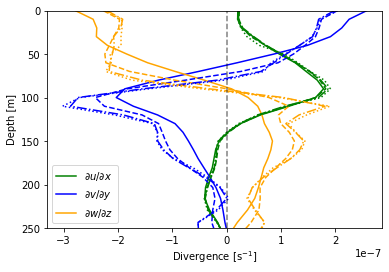

In [6]:
# plot divergences -> they look pretty good i think

plt.plot(dudx1, zw[:30], label=r'$\partial u/ \partial x$', c='green', ls='-')
plt.plot(dvdy1, zw[:30], label=r'$\partial v/\partial y$', c='blue', ls='-')
plt.plot(-(dvdy1+dudx1), zw[:30], label='$\partial w / \partial z$', c='orange', ls='-')
plt.plot(dudx05, zw[:30], c='green', ls='--')
plt.plot(dvdy05, zw[:30], c='blue', ls='--')
plt.plot(-(dvdy05+dudx05), zw[:30], c='orange', ls='--')
plt.plot(dudx02, zw[:30], c='green', ls='-.')
plt.plot(dvdy02, zw[:30], c='blue', ls='-.')
plt.plot(-(dvdy02+dudx02), zw[:30], c='orange', ls='-.')
plt.plot(dudx01, zw[:30], c='green', ls=':')
plt.plot(dvdy01, zw[:30], c='blue', ls=':')
plt.plot(-(dvdy01+dudx01), zw[:30], c='orange', ls=':')
plt.ylim(0,250)
plt.gca().invert_yaxis()
plt.axvline(0, c='k', alpha=0.5, ls='--')
plt.legend()
plt.ylabel('Depth [m]')
plt.xlabel(r'Divergence [s$^{-1}$]')
plt.savefig('JRA55_IAF_tavg_divergences_around_0E140W_t.png', bbox_inches='tight')

In [7]:
# integrate dw/dz to arrive at w

w1 = int_dwdz(dudx1, dvdy1, dz[:30])
w05 = int_dwdz(dudx05, dvdy05, dz[:30])
w02 = int_dwdz(dudx02, dvdy02, dz[:30])
w01 = int_dwdz(dudx01, dvdy01, dz[:30])

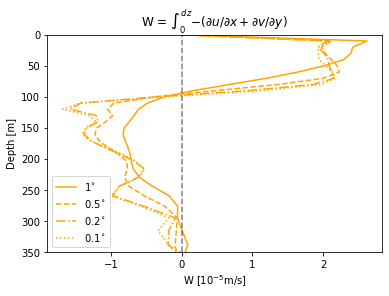

In [8]:
# plot differently obtained w -> also looks okay?

plt.plot(-w1*10e5, zw[:30], label=r'1$^{\circ}$', c='orange', ls='-')
plt.plot(-w05*10e5, zw[:30], label=r'0.5$^{\circ}$', c='orange', ls='--')
plt.plot(-w02*10e5, zw[:30], label=r'0.2$^{\circ}$', c='orange', ls='-.')
plt.plot(-w01*10e5, zw[:30], label=r'0.1$^{\circ}$', c='orange', ls=':')
plt.ylim(0,350)
plt.gca().invert_yaxis()
plt.axvline(0, c='k', alpha=0.5, ls='--')
plt.legend()
plt.title(r'W = $\int_{0}^{dz}{- (\partial u / \partial x + \partial v / \partial y )}$')
plt.ylabel('Depth [m]')
plt.xlabel(r'W [10$^{-5}$m/s]')
plt.savefig('JRA55_IAF_tavg_wfromdivergences_around_0E140W.png', bbox_inches='tight')

In [ ]:
# manually test the integration -> maybe something is wrong? 



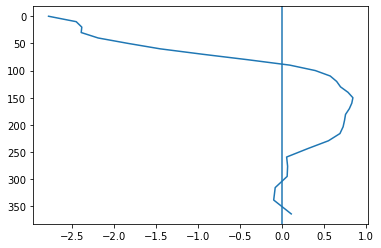

In [9]:
# check what's going on here 

ww1 = ( dvdy1 + dudx1 ) * dz[:30] # why is this the wrong way around
plt.plot(-ww1*10e5, zw[:30])
plt.axvline(0)
plt.gca().invert_yaxis()

In [87]:
cs = plt.rcParams['axes.prop_cycle'].by_key()['color']


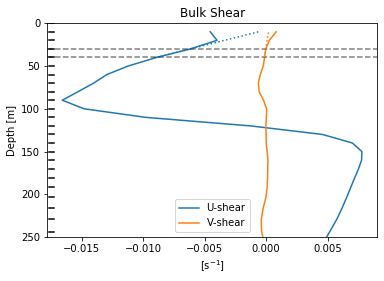

In [127]:
# test the shear assumption -> interpolated linearly up from 40m
# calc shear but make sure it's on correct points on grid
shry = (VVEL[:-1,j_eq, i_140w] - VVEL[1:,j_eq, i_140w]) / dzw[1:]
shrx = (UVEL[:-1,j_eq, i_140w] - UVEL[1:,j_eq, i_140w]) / dzw[1:]

# interpolate from 40-30 up 
dshy = shry[3] - shry[2]
dshx = shrx[3] - shrx[2]
intshry = [(shry[3]),(shry[3]-dshy),(shry[3]-2*dshy),(shry[3]-3*dshy)]
intshrx = [(shrx[3]),(shrx[3]-dshx),(shrx[3]-2*dshx),(shrx[3]-3*dshx)]

fig, ax = plt.subplots(1,1, figsize=cm2inch(15,10))
ax.set_title('Bulk Shear')
ax.set_ylabel('Depth [m]')
ax.set_xlabel(r'[s$^{-1}$]')
ax.plot(shrx, zw[1:], label='U-shear', c=cs[0])
ax.plot(shry, zw[1:], label='V-shear', c=cs[1])
ax.set_ylim(0,250)
ax.axhline(30, c='k', ls='--', alpha=0.5)
ax.axhline(40, c='k', ls='--', alpha=0.5)
ax.legend()
for z in zw:
    ax.axhline(z,0.005,0.02, c='k')
    
#ax[0].scatter(intshry, zw[1:5][::-1], label='interp V-shear')
ax.plot(intshry, zw[1:5][::-1], c=cs[1], ls=':')
#ax[0].scatter(intshrx, zw[1:5][::-1], label='interp U-shear')
ax.plot(intshrx, zw[1:5][::-1], c=cs[0], ls=':')
ax.invert_yaxis()

plt.savefig('bulk_shear_140W0E_JRA55_tavg_linint.png', bbox_inches='tight')

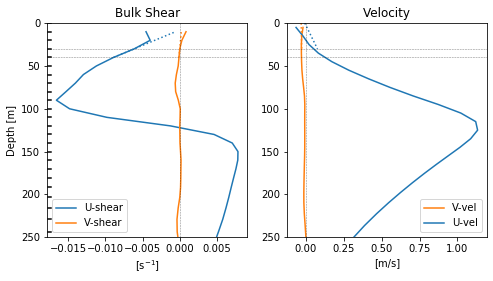

In [160]:
shry = (VVEL[:-1,j_eq, i_140w] - VVEL[1:,j_eq, i_140w]) / dzw[1:]
shrx = (UVEL[:-1,j_eq, i_140w] - UVEL[1:,j_eq, i_140w]) / dzw[1:]

# interpolate from 40-30 up 
dshy = shry[3] - shry[2]
dshx = shrx[3] - shrx[2]
intshry = [(shry[3]),(shry[3]-dshy),(shry[3]-2*dshy),(shry[3]-3*dshy)]
intshrx = [(shrx[3]),(shrx[3]-dshx),(shrx[3]-2*dshx),(shrx[3]-3*dshx)]

# ! something is weird here, need to figure this out
# get velocity back from interpolated shear
intdvely = np.asarray(intshry) * dzw[1:5][::-1]
intdvelx = np.asarray(intshrx) * dzw[1:5][::-1]

intvely = VVEL[3, j_eq, i_140w] + intdvely
intvelx = UVEL[3, j_eq, i_140w] + intdvelx

fig, ax = plt.subplots(1,2, figsize=cm2inch(20,10))
ax[0].set_title('Bulk Shear')
ax[0].set_ylabel('Depth [m]')
ax[0].set_xlabel(r'[s$^{-1}$]')
ax[0].plot(shrx, zw[1:], label='U-shear', c=cs[0])
ax[0].plot(shry, zw[1:], label='V-shear', c=cs[1])
ax[0].set_ylim(0,250)
ax[0].axhline(30, c='k', ls='--', alpha=0.5, lw=0.5)
ax[0].axhline(40, c='k', ls='--', alpha=0.5, lw=0.5)
ax[0].legend()
for z in zw:
    ax[0].axhline(z,0.005,0.02, c='k')
    
#ax[0].scatter(intshry, zw[1:5][::-1], label='interp V-shear')
ax[0].plot(intshry, zw[1:5][::-1], c=cs[1], ls=':')
#ax[0].scatter(intshrx, zw[1:5][::-1], label='interp U-shear')
ax[0].plot(intshrx, zw[1:5][::-1], c=cs[0], ls=':')
ax[0].invert_yaxis()
ax[0].axvline(0, ls='--', c='k', lw=0.5, alpha=0.5)

ax[1].set_title('Velocity')
ax[1].plot(VVEL[:30,j_eq, i_140w], zt[:30], c=cs[1], label='V-vel')
ax[1].plot(UVEL[:30,j_eq, i_140w], zt[:30], c=cs[0], label='U-vel')
ax[1].legend()
ax[1].set_ylim(0,250)
ax[1].plot(intvely, zw[0:4], c=cs[1], ls=':')
ax[1].plot(intvelx, zw[0:4], c=cs[0], ls=':')
ax[1].invert_yaxis()
ax[1].axvline(0, ls='--', c='k', lw=0.5, alpha=0.5)
ax[1].set_xlabel('[m/s]')
ax[1].axhline(30, c='k', ls='--', alpha=0.5, lw=0.5)
ax[1].axhline(40, c='k', ls='--', alpha=0.5, lw=0.5)

plt.savefig('bulk_shear_140W0E_JRA55_tavg_linint_vel.png', bbox_inches='tight')

# note to self: check calc from shear to vel, make sure all depth indices are correctly assigned

I'm off by a factor 100..


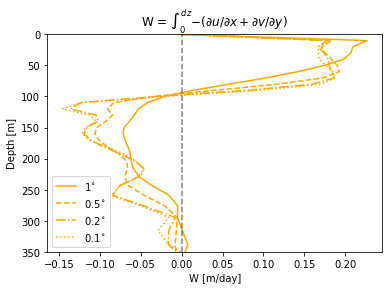

In [42]:
# plot in m / day 
day_factor = 60.*60.*24
plt.plot(-w1*day_factor, zw[:30], label=r'1$^{\circ}$', c='orange', ls='-')
plt.plot(-w05*day_factor, zw[:30], label=r'0.5$^{\circ}$', c='orange', ls='--')
plt.plot(-w02*day_factor, zw[:30], label=r'0.2$^{\circ}$', c='orange', ls='-.')
plt.plot(-w01*day_factor, zw[:30], label=r'0.1$^{\circ}$', c='orange', ls=':')
plt.ylim(0,350)
plt.gca().invert_yaxis()
plt.axvline(0, c='k', alpha=0.5, ls='--')
plt.legend()
plt.title(r'W = $\int_{0}^{dz}{- (\partial u / \partial x + \partial v / \partial y )}$')
plt.ylabel('Depth [m]')
plt.xlabel(r'W [m/day]')
#plt.savefig('JRA55_IAF_tavg_wfromdivergences_around_0E140W.png', bbox_inches='tight')
print('I\'m off by a factor 100..')

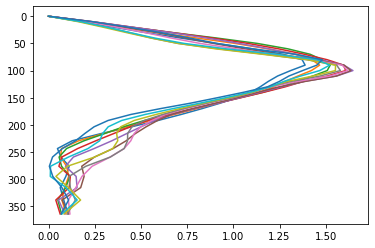

In [49]:
# W should be in this envelope - but obviously isn't
for i in np.arange(-5,6):
    plt.plot(WVEL[:30,j_eq+i, i_140w], zw[:30])
plt.gca().invert_yaxis()

Text(0.5, 1.0, 'JRA IAF 21 year average velocity profiles at 140$^{\\circ}$W, 0$^{\\circ}$E')

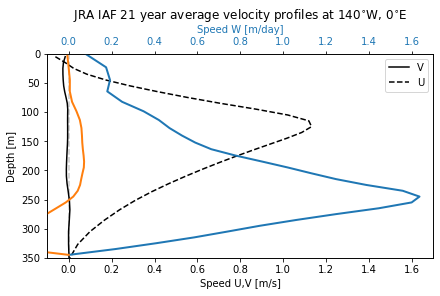

In [43]:
# first plot u and v and w from model output, at 140W and Eq
# remember that WVEL is converted to m/day -> is everything else in m? 
# something is fishy. 

fig1, ax = plt.subplots(constrained_layout=True)
ax.plot(VVEL[:30,j_eq,i_140w], zt[:30], label='V', c='k', ls='-')
ax.plot(UVEL[:30,j_eq,i_140w], zt[:30], label='U', c='k', ls='--')
ax.set_xlabel('Speed U,V [m/s]')
ax.set_xlim(-0.1,1.7)
ax.axvline(0, c='k', alpha=0.2, ls='--')
axw = ax.twiny()
axw.set_xlim(-0.1,1.7)
[i.set_color("#1f77b4") for i in axw.get_xticklabels()]
axw.plot(WVEL[:30,j_eq,i_140w], zt[:30], label='W', lw=2)
#axw.plot(w_int, zt[:30], label='W_int', lw=2)
axw.plot(w1*w_factor*100, zt[:30], label='W', lw=2)
#axw.invert_yaxis()

axw.set_xlabel('Speed W [m/day]', c='#1f77b4')
ax.legend()
ax.set_ylim(0,350)
ax.invert_yaxis()
ax.set_ylabel('Depth [m]')
ax.set_title(r'JRA IAF 21 year average velocity profiles at 140$^{\circ}$W, 0$^{\circ}$E')